In [1]:
# %conda env update -f env.yml

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.10.3
  latest version: 4.11.0

Please update conda by running

    $ conda update -n base conda


Installing pip dependencies: - Ran pip subprocess with arguments:
['/home/studio-lab-user/.conda/envs/hackathon_data/bin/python', '-m', 'pip', 'install', '-U', '-r', '/home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/notebooks/condaenv.uqvvz_td.requirements.txt']
Pip subprocess output:

done
#
# To activate this environment, use
#
#     $ conda activate /home/studio-lab-user/.conda/envs/hackathon_data
#
# To deactivate an active environment, use
#
#     $ conda deactivate


Note: you may need to restart the kernel to use updated packages.


[![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/SatelliteVu/SatelliteVu-AWS-Disaster-Response-Hackathon/blob/main/dataset_preparation/1_TrainingDataCreation.ipynb)

In [2]:
from concurrent.futures import ThreadPoolExecutor
from datetime import datetime, timedelta
import os
from pathlib import Path
from random import sample
import shutil
import subprocess

import geopandas as gpd
import numpy as np
import pandas as pd
import s3fs
from shapely.geometry import box 
import rasterio
from rasterio.errors import RasterioIOError

In [3]:
from src.constants import DEFAULT_PARAMS
from src.data_sources import (unzip_csvs,
                              cluster_fires, 
                              create_chip_bounds, 
                              ndvi_from_topleft, 
                              landcover_from_topleft, 
                              atmospheric_from_topleft, 
                              fires_from_topleft,
                              elevation_from_topleft)

# Input parameters

In [4]:
output_fp = '/home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test'
output_s3 = os.environ['AWS_S3_BUCKET'] + '/train_test'

In [5]:
fs = s3fs.S3FileSystem(key=os.environ['AWS_ACCESS_KEY_ID'], secret=os.environ['AWS_SECRET_ACCESS_KEY'])

# Load fires & create chip metadata

In [6]:
%%time

# fires = ["https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIREd_SV-C2_243916.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243915.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243914.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243913.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243912.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243910.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243911.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243909.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243908.zip", "https://firms.modaps.eosdis.nasa.gov/data/download/DL_FIRE_SV-C2_243907.zip"]
fire_zips = ["fires_2012.zip","fires_2013.zip", "fires_2014.zip", "fires_2015.zip", "fires_2016.zip", "fires_2017.zip", "fires_2018.zip", "fires_2019.zip", "fires_2020.zip", "fires_2021.zip"]
fires = [f"{os.environ['AWS_S3_BUCKET']}/{x}" for x in fire_zips]

downloaded_fires = []
fire_gpkgs = []
manifest = pd.DataFrame()
for fire in fires:
    downloaded_path = Path(output_fp).joinpath(fire.split('/')[-1])
    print(f"Downloading {fire.split('/')[-1]} to {downloaded_path}")
    fs.download(fire, str(downloaded_path))
    
    # unzip
    print('Unzipping')
    unzipped = unzip_csvs(downloaded_path)
    
    # read csv - 2021 zip has two csvs - archive + NRT
    for fire_csv in unzipped:
        print(f'Loading fire_csv: {fire_csv}')
        df = gpd.read_file(fire_csv)
        df_fire = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs='EPSG:4326')
        
        # saving fire points to geopackage
        fire_gpkg = fire_csv.with_suffix('.gpkg')
        print(f'Saving fires to gpkg: {fire_gpkg}')
        df_fire[['acq_date','frp','geometry']].to_file(fire_gpkg, driver="GPKG")
        fire_gpkgs.append(fire_gpkg)
        
        # create clusters
        print('Clustering fires')
        df_fire_clustered = cluster_fires(df_fire)

        # create/append chip bounds to records csv
        print('Creating chip bounds')
        chip_bounds = create_chip_bounds(df_fire_clustered)
        if manifest.empty:
            manifest=chip_bounds
        else:
            chip_bounds.idx = chip_bounds.idx + manifest.idx.max() + 1
            manifest = pd.concat([manifest, chip_bounds])
        
        # delete unzipped csv
        fire_csv.unlink()
    
    # delete downloaded fire zip
    downloaded_path.unlink()

# free some memory
df = None
df_fire = None


Unzipping
Loading fire_csv: /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243916.csv
Saving fires to gpkg: /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243916.gpkg
Clustering fires
Creating chip bounds
Unzipping
Loading fire_csv: /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243915.csv
Saving fires to gpkg: /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243915.gpkg
Clustering fires
Creating chip bounds
Unzipping
Loading fire_csv: /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243914.csv
Saving fires to gpkg: /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243914.gpkg
Clustering fires
Creating chip bounds
Unzipping
Loading fire_csv: /home/studio-lab-user/sagemaker-studiolab-notebooks/hacka

In [7]:
records_csv = Path(output_fp).joinpath('records.csv')
manifest.to_csv(records_csv, index=False)
# manifest = pd.read_csv(records_csv)
manifest

,idx,left,bottom,right,top,epsg,date
0,0,493000.0,3087500.0,525000.0,3119500.0,32617,2012-01-20
1,1,351500.0,3336000.0,383500.0,3368000.0,32617,2012-01-20
2,2,722000.0,3320000.0,754000.0,3352000.0,32616,2012-01-20
3,3,416000.0,3282000.0,448000.0,3314000.0,32615,2012-01-24
4,4,351500.0,3342000.0,383500.0,3374000.0,32617,2012-01-26
...,...,...,...,...,...,...,...
812,43359,247500.0,4047500.0,279500.0,4079500.0,32614,2021-12-15
813,43360,546500.0,4059500.0,578500.0,4091500.0,32614,2021-12-15
814,43361,738000.0,3933500.0,770000.0,3965500.0,32613,2021-12-15
815,43362,477000.0,4313500.0,509000.0,4345500.0,32614,2021-12-16


In [8]:
%%time

# merge geopackages into one
output_gpkg = str(Path(output_fp).joinpath("fires.gpkg"))
for n, fire_gpkg in enumerate(fire_gpkgs):
    print(n, fire_gpkg)
    if n == 0:
        subprocess.run(["ogr2ogr", output_gpkg, fire_gpkg, "-nln", "merge"])
    else:
        subprocess.run(["ogr2ogr", "-update", "-append", output_gpkg, fire_gpkg, "-nln", "merge"])
    fire_gpkg.unlink()

0 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243916.gpkg
1 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243915.gpkg
2 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243914.gpkg
3 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243913.gpkg
4 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243912.gpkg
5 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243910.gpkg
6 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243911.gpkg
7 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243909.gpkg
8 /home/studio-lab-user/sagemaker-studiolab-notebooks/hackathon_data/train_test/fire_archive_SV-C2_243908.gpkg
9

# Process Chips

In [9]:
def process_chip(chip, fs, output_fp, output_s3, fires, cog_footprints, training=True):
    """
    Given a chips metadata, load all of the training data and write numpy files, finally upload results to S3
    :param chip: records.csv chip to process data for
    :param fs: s3fs.S3FileSystem
    :param output_fp: local directory to write data to
    :param output_s3: local directory to write data to
    :param fires: gpd.GeoDataFrame or path to vector file containing fire point data
    :param cog_footprints: gpd.GeoDataFrame of the dem footprints
    :param training: bool, if true then will load/write next days fires
    """
    chip_idx, left, bottom, top, right, epsg, chip_date = chip["idx"], chip["left"], chip["bottom"], chip["top"], chip["right"], chip["epsg"], chip["date"]
    
    if os.path.exists(output_fp + f'/{chip_idx}'):
        return
    
    # check not already on s3
    if len(fs.ls(f'{output_s3}/{chip_idx}')) != 0:
        return
    
    print(f'Processing chip: {chip_idx}')
    
    # create output dir if it doesnt already exist
    output_dir = Path(output_fp).joinpath(str(chip_idx))
    output_dir.mkdir(parents=True, exist_ok=True)

    # load modis
    try:
        ndvi = ndvi_from_topleft([top, left], epsg, chip_date)
        np.save(output_dir.joinpath('ndvi.npy'), ndvi)
    except RasterioIOError:
        # modis missing from bucket
        shutil.rmtree(output_dir)
        return
    
    # save bbox to geojson
    bounds_utm = rasterio.coords.BoundingBox(left=left, right=right, bottom=bottom, top=top)
    gpd.GeoSeries([box(*bounds_utm)]).set_crs(epsg).to_file(output_dir.joinpath('bbox.geojson'))
    
    # load fires
    todays_fires = fires_from_topleft([top, left], epsg, chip_date, fires=fires)
    np.save(output_dir.joinpath(f'todays_fires.npy'), todays_fires.bool)
    np.save(output_dir.joinpath(f'todays_frp.npy'), todays_fires.frp)
    
    # load tomorrows fires if training
    if training:
        tomorrows_date = (datetime.strptime(chip_date, '%Y-%m-%d') + timedelta(days=1)).strftime('%Y-%m-%d')
        tomorrows_fires = fires_from_topleft([top, left], epsg, tomorrows_date, fires=fires)
        np.save(output_dir.joinpath(f'tomorrows_fires.npy'), tomorrows_fires.bool)
        np.save(output_dir.joinpath(f'tomorrows_frp.npy'), tomorrows_fires.frp)
    
    # load dem
    dem = elevation_from_topleft([top, left], epsg, cog_footprints)
    np.save(output_dir.joinpath('elevation.npy'), dem)
    
    # load landcover
    landcover = landcover_from_topleft([top, left], epsg)
    np.save(output_dir.joinpath('landcover.npy'), landcover)
    
    # load atmospheric
    atmos = atmospheric_from_topleft([top, left], epsg, chip_date, DEFAULT_PARAMS)
    for var in list(atmos.data_vars):
        data_arr = getattr(atmos, var).values[0]
        np.save(output_dir.joinpath(f'{var}.npy'), data_arr)
    
    fs.upload(str(output_dir), 
              f'{output_s3}/{chip_idx}/',
             recursive=True)
    shutil.rmtree(output_dir)

In [10]:
chips = list(manifest.T.to_dict().values())
print(f'Chips total = {len(chips)}')
# query s3 to see which chips already processed and remove from list
processed_chips = fs.ls(output_s3)
processed_ids = [int(x.split('/')[-1]) for x in processed_chips if x.split('/')[-1].isdigit()]
print(f'Processed = {len(processed_ids)}')
to_process = [x for x in chips if x['idx'] not in processed_ids]
print(f'To process = {len(to_process)}')

/tmp/ipykernel_156/2655859489.py:1: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  chips = list(manifest.T.to_dict().values())


Chips total = 6308
Processed = 0
To process = 6308


In [11]:
to_process_sample = sample(to_process, 10)
to_process_sample[0]

{'idx': 42080,
 'left': 575000.0,
 'bottom': 4574000.0,
 'right': 607000.0,
 'top': 4606000.0,
 'epsg': 32610,
 'date': '2021-08-19'}

In [28]:
%%time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

os.environ['AWS_NO_SIGN_REQUEST'] = 'True'
cog_footprints = gpd.GeoDataFrame.from_file('s3://copernicus-dem-30m/grid.zip')

with ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    future_work = [
        executor.submit(process_chip, chip, fs, output_fp, output_s3, str(output_gpkg), cog_footprints) for chip in to_process_sample
    ]

Already processed on AWS S3
Processing chip: 42080
Processing chip: 40270Processing chip: 39476

Processing chip: 39170


ERROR 1: No input dataset specified.


Already processed on AWS S3
Already processed on AWS S3
Processing chip: 39856
Already processed on AWS S3
Already processed on AWS S3
CPU times: user 35.3 s, sys: 11.7 s, total: 46.9 s
Wall time: 35 s


# Explore some of the processed chips

39476


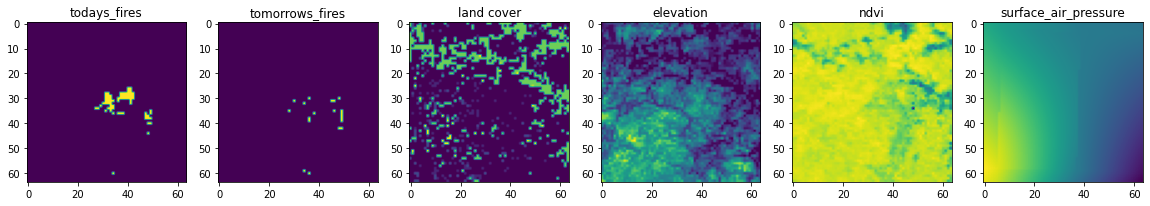

40270


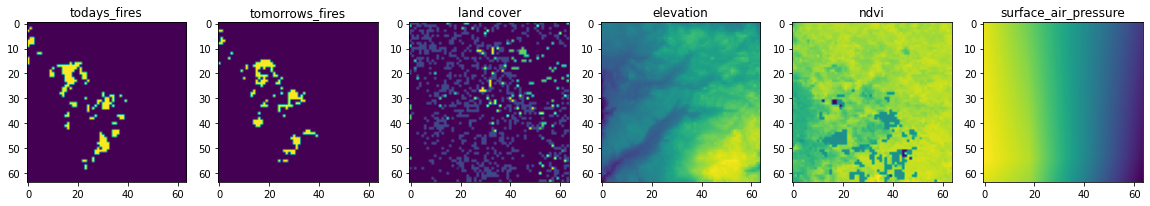

39856


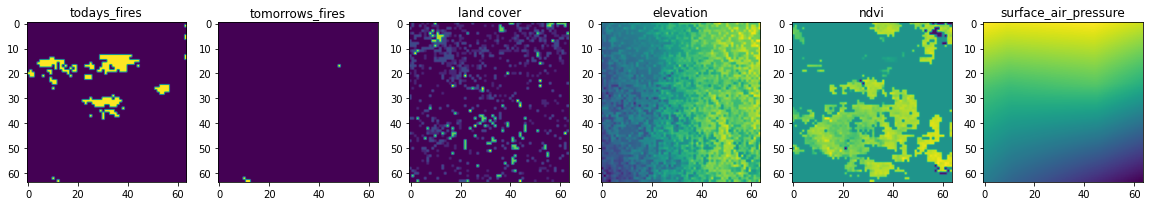

39170


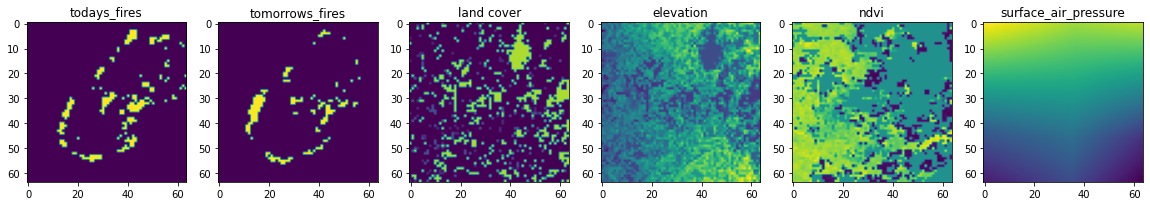

In [31]:
import matplotlib.pyplot as plt

random_chips = sample([x for x in fs.ls(output_s3) if x.split('/')[-1].isdigit()], 4)

for chip in random_chips:
    print(chip.split('/')[-1])
    
    try:
        tf = np.load(fs.open(chip + '/todays_fires.npy'))
    except FileNotFoundError:
        continue
        
    fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(1, 6, figsize=(20,20))

    im = ax1.imshow(tf)
    ax1.title.set_text('todays_fires')
    
    tf2 = np.load(fs.open(chip + '/tomorrows_fires.npy'))
    im = ax2.imshow(tf2)
    ax2.title.set_text('tomorrows_fires')
    
    lc = np.load(fs.open(chip + '/landcover.npy'))
    im = ax3.imshow(lc)
    ax3.title.set_text('land cover')

    el = np.load(fs.open(chip + '/elevation.npy'))
    im = ax4.imshow(el)
    ax4.title.set_text('elevation')
    
    nd = np.load(fs.open(chip + '/ndvi.npy'))
    im = ax5.imshow(nd)
    ax5.title.set_text('ndvi')
    
    sa = np.load(fs.open(chip + '/surface_air_pressure.npy'))
    im = ax6.imshow(sa)
    ax6.title.set_text('surface_air_pressure')
    
    plt.show()